In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2024 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by: Philip Elbek (DTU)
#               Markus Tandrup Holm (DTU)
#               Anna Dalklint (DTU)
#  Edited by: Chao Zhang (DTU)
#  Reviewed by: Jakob Sauer Jørgensen (DTU)

# Stiffness uncertainty of a spring system
### Philip Elbek (phiel@dtu.dk)
### Markus Tandrup Holm (mtaho@dtu.dk)
### Anna Dalklint (adal@dtu.dk)

A [spring system](https://www.wikiwand.com/en/Spring_system) is an elastic device that stores mechanical energy when subjected to deformation and releases it when the force causing the deformation is removed. They are used to model a wide range of real-world phenomena, such as vibrations in buildings and bridges, the motion of atoms in molecules, and the behavior of suspension systems in cars. This notebook explores the use of CUQIpy in inferring the stiffness coefficients of a spring system based on node displacements.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import cuqi
from cuqi.distribution import JointDistribution
from cuqi.sampler import MH
from cuqi.geometry import Discrete

In [3]:
# Set random seed
np.random.seed(0)

In [4]:
print("cuqi version: ", cuqi.__version__)

cuqi version:  0.8.0.post0.dev89


## Problem description
### Forward model

Consider a spring which is pulled at the end with a force $f$ [N]. If the spring has uniform stiffness $k$ [N/m], the displacement of its right end would simply be $u = f/k$. 
Consider now the spring having non-uniform stiffness along its length. This can be expressed as a series of linear springs with individual stiffnesses and be written as a system of linear equations.

$$Ku = f$$
or equivalently as 

$$u = K^{-1}f$$

The above system will be our forward model and it maps stiffness values $k$ to displacements $u$. The derivation of the stiffness matrix is shown below for 3 springs. Each red box is the equilibrium at each node, which depends on neigboring springs.


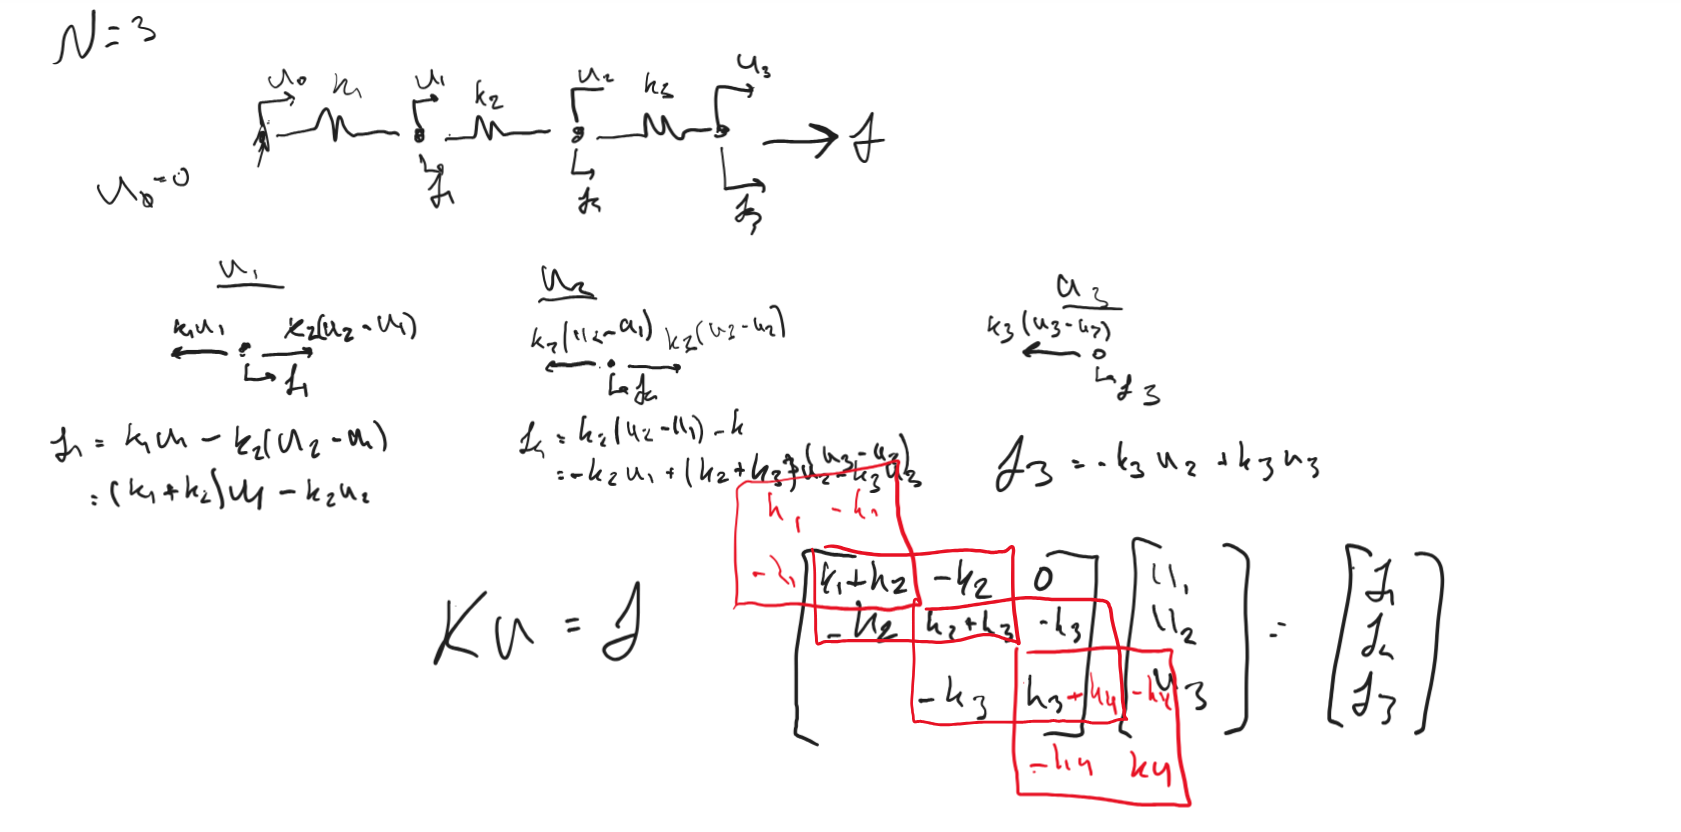

Here, we define a function `KinvF` that takes `k` as input and returns the `u`.

In [5]:
nelm = 4 # Number of elements
nnod = nelm+1 # Number of nodes
L = 1 # Length of bar
Le = L/nelm # Element length
F = 1 # Force at the end of bar

# Solves the linear set of equations, Ku=f, for u.
def KinvF(k):
    f = np.zeros(nnod) # Init f
    f[nelm] = F # Set force at last node of f
    K = np.zeros((nnod,nnod)) # Init stiffness matrix K
    for i in range(nelm): 
        ke = 1/Le*np.array([
            [k[i], -k[i]],
            [-k[i], k[i]]])
        K[i:i+2, i:i+2] += ke # Insert local stiffness matrix in K.
    K = K[1:,1:] # Apply boundary condition by removing first node
    f = f[1:]
    u = np.matmul(np.linalg.inv(K),f) # Solve for u
    return u

A CUQIpy `Model` object can then be created with this `KinvF` function.

In [6]:
model_func = cuqi.model.Model(KinvF, range_geometry=Discrete(nelm), domain_geometry=Discrete(nelm))
print(model_func)

CUQI Model: Discrete(4,) -> Discrete(4,).
    Forward parameters: ['k'].


### Data generation

We define the exact stiffness of a _hat_ shape, with higer values in the middle and lower values at the ends. Fake measurement data is then generated by adding some Gaussian noise to function output with the exact stiffness.

4


Text(0, 0.5, 'value')

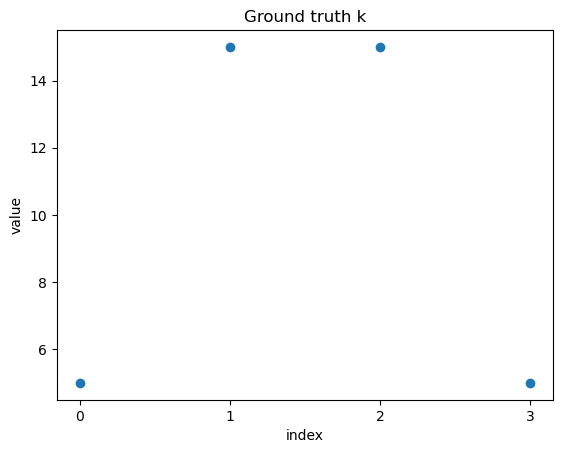

In [7]:
def hat(nelm):
    # Hat function, used for k, This is what we want to recreate using realizations
    c = 5 # Minimum value at ends
    A = 20 # Maximum value in middle
    k = np.zeros(nelm)
    print(len(k))
    incr = np.linspace(0,int(np.floor(nelm/2)-1),int(np.floor(nelm/2)))
    decr = np.linspace(int(np.floor(nelm/2)),nelm-1,int(np.ceil(nelm/2)))
    k[:int(np.floor(nelm/2))] = 2*(A-c)*(incr)/(nelm-1)+c
    k[int(np.floor(nelm/2)):] = 2*(c-A)*decr/(nelm-1)+(2*A-c)
    return k

k_exact = hat(nelm) # Setting exact values of element stiffnesses to be a hat function.

plt.figure()
plt.plot(k_exact,'o')
plt.title("Ground truth k")
plt.xticks(range(nelm))
plt.xlabel('index')
plt.ylabel('value')


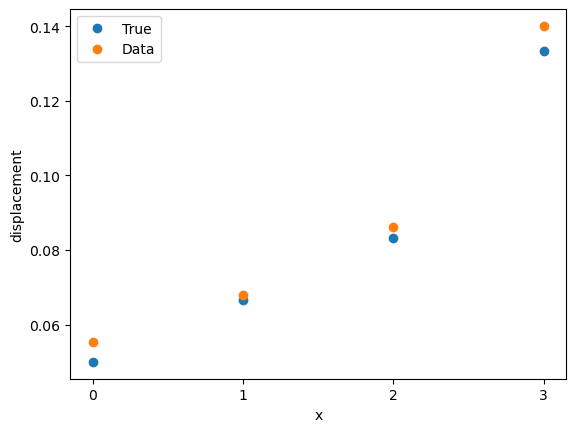

In [8]:
# The exact displacement function and perturbed displacement function can be plottet against each other.
u_exact = model_func(k=k_exact)
noise_level = 0.003
u_data = u_exact + noise_level*np.random.randn(nelm)

plt.figure()
plt.plot(u_exact, 'o')
plt.plot(u_data, 'o')
plt.xlabel('x')
plt.xticks(range(nelm))
plt.ylabel('displacement')
plt.legend(["True","Data"])

## Bayesian inference

### Prior and likelihood

A natural guess of the element stiffness would be the average value of the whole spring system, which can be easily calculated with the force and displacment observed at the last spring.

\begin{align*}
\mathbf{k} &\sim \mathcal{N}(\mu_{k}, s_\mathbf{k}^2 I)
\end{align*}


In [9]:
s_k = 10
mu_k = F/u_data[nelm-1]*np.ones(nelm) # mu_k is defined as the average of all springs
k = cuqi.distribution.Gaussian(mu_k,s_k**2)
print(k)

CUQI Gaussian.


And we assume the measurement data is subject to Gaussian noise, so

\begin{align*}
\mathbf{u} \mid \mathbf{k} &\sim \mathcal{N}(\mathbf{K}(k)^{-1}\mathbf{f}, s_\mathbf{u}^2 \mathbf{I}),
\end{align*}

In [10]:
s_u = 0.01
u = cuqi.distribution.Gaussian(model_func(k),noise_level**2)
print(u)

CUQI Gaussian. Conditioning variables ['k'].


## Drawing from posterior

By taking a MCMC approach, we seek to draw samples from the following posterior distribution:

\begin{align*}
p(\mathbf{k} \mid \mathbf{u}=\mathbf{u}_\mathrm{data}) \propto L(\mathbf{k} \mid \mathbf{u}=\mathbf{u}_\mathrm{data})p(\mathbf{k}),
\end{align*}

In [11]:
# Defining joint distribution
joint = JointDistribution(u, k)
print(joint)

JointDistribution(
    Equation: 
	p(u,k) = p(u|k)p(k)
    Densities: 
	u ~ CUQI Gaussian. Conditioning variables ['k'].
	k ~ CUQI Gaussian.
)


In [12]:
# Defining posterior
posterior = joint(u=u_data)
print(posterior)

Posterior(
    Equation:
	 p(k|u) ∝ L(k|u)p(k)
    Densities:
	u ~ CUQI Gaussian Likelihood function. Parameters ['k'].
 	k ~ CUQI Gaussian.
 )


Here, we choose the basic Metropolis-Hastings sampler and tune the acceptance rate to be arround 23.4%.

Sample 60000 / 60000

Average acceptance rate: 0.23514 MCMC scale: 0.416287636964797 



array([[<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v0'}>],
       [<Axes: title={'center': 'v1'}>, <Axes: title={'center': 'v1'}>],
       [<Axes: title={'center': 'v2'}>, <Axes: title={'center': 'v2'}>],
       [<Axes: title={'center': 'v3'}>, <Axes: title={'center': 'v3'}>]],
      dtype=object)

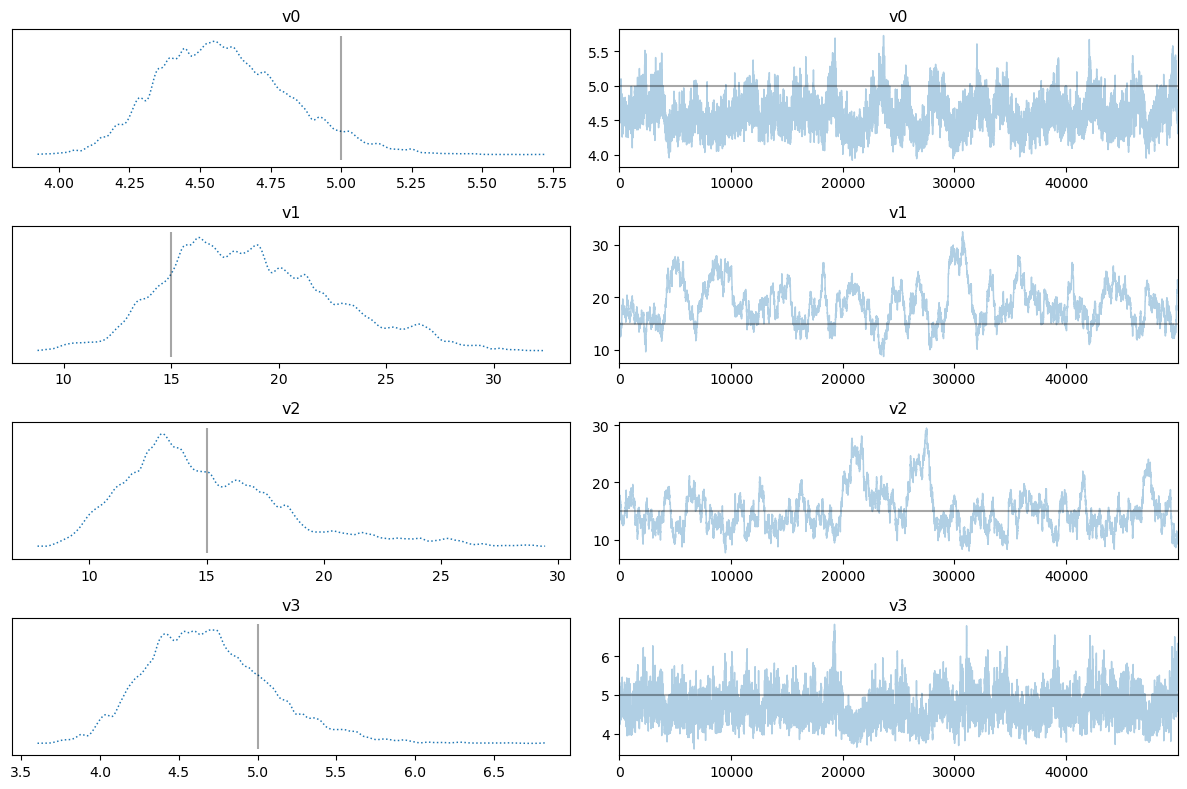

In [13]:
# Sampling the posterior
sampler = MH(posterior,x0=mu_k,scale=0.4)
samples = sampler.sample_adapt(50000,10000)
samples.plot_trace(exact=k_exact)

 <ErrorbarContainer object of 3 artists>]

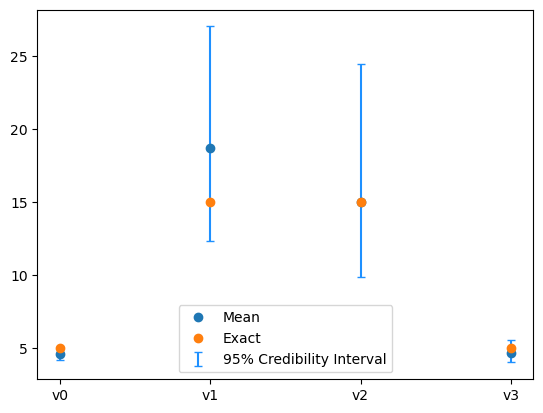

In [14]:
samples.plot_ci(exact=k_exact)

While the posterior samples seem to converge to the exact values, there exhibits strong correlation between samples, particularly in the 2nd and 3rd parameter. This is an inherent drawback of the MH sampler and could be eleviated by choosing a gradient-based sampler, for example MALA and HMC, which are not explored in this notebook.